In [209]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [210]:
# 한글 폰트 사용을 위한 설정
import matplotlib.font_manager as fm 
import matplotlib 

font_path = 'C:/Windows/Fonts/gulim.ttc'
font = fm.FontProperties(fname=font_path).get_name()
matplotlib.rc('font', family=font)

In [211]:
# 2019~ 데이터셋 
dfs = pd.read_csv('./data/2019.csv')

# 축종별 수입 소비자가격 데이터
imdf = pd.read_csv('./data/import_meat.csv')

dfs.head(2)

,고기,연도,1월,2월,3월,4월,5월,6월,7월,8월,9월,10월,11월,12월,Unnamed: 14
0,소 1 ++,2019,NaN,NaN,NaN,NaN,NaN,11388,12001,12472.0,13043.0,13359.0,13148.0,13450.0,NaN
1,소 1 ++,2020,13620.0,13730.0,13394.0,13117.0,13884.0,13458,14330,14229.0,14310.0,14531.0,14257.0,14597.0,NaN


### 전처리

In [ ]:
# 축종별 수입 소비자가격 데이터
num_cols = [col for col in imdf.columns if col not in ['구분', '부위', '원산지별']]
imdf[num_cols] = imdf[num_cols].apply(pd.to_numeric, errors='coerce')

imdf = imdf.drop(['부위', '원산지별'], axis=1)

imdf = imdf.groupby('구분').mean()

imdf = imdf.T

imdf.index = imdf.index.str.replace(' ', '', regex=False)
imdf.index = pd.to_datetime(imdf.index, format='%Y.%m')

# - 가격 변동률
imdf_pct = imdf.pct_change() * 100

In [212]:
# 국내 전체 축종별 소비자가격 데이터
dfs['고기'] = dfs['고기'].replace({'소 1': '소', '소 1 ++': '소'})
dfs = dfs.loc[:, ~dfs.columns.str.contains('^Unnamed')]

dff = dfs.melt(id_vars=['고기', '연도'], var_name='월', value_name='가격')

dff['가격'] = dff.groupby(['고기', '연도', '월'])['가격'].transform(lambda x: x.fillna(x.mean()))
dff = dff.groupby(['고기', '연도', '월'])['가격'].mean().reset_index()

month = {'1월': '01', '2월': '02', '3월': '03', '4월': '04', '5월': '05', '6월': '06','7월': '07', '8월': '08', '9월': '09', '10월': '10', '11월': '11', '12월': '12'}
dff['월'] = dff['월'].map(month)
dff['yyyydd'] = pd.to_datetime(dff['연도'].astype(str) + '.' + dff['월'], format='%Y.%m')
dff['날짜'] = dff['yyyydd'].dt.to_period('M').astype(str)
dff = dff.sort_values(by='날짜')

dff[dff['고기'] == '소']

dff['가격'] = dff.groupby(['고기', '날짜'])['가격'].transform(lambda x: x.fillna(x.mean()))

dff_pivot = dff.pivot(index='날짜', columns='고기', values='가격')
dff_pivot.index = pd.to_datetime(dff_pivot.index)
dff_pivot = dff_pivot.dropna()

# - 가격 변동률
dff_pivot_pct = dff_pivot.pct_change() * 100

### 시각화

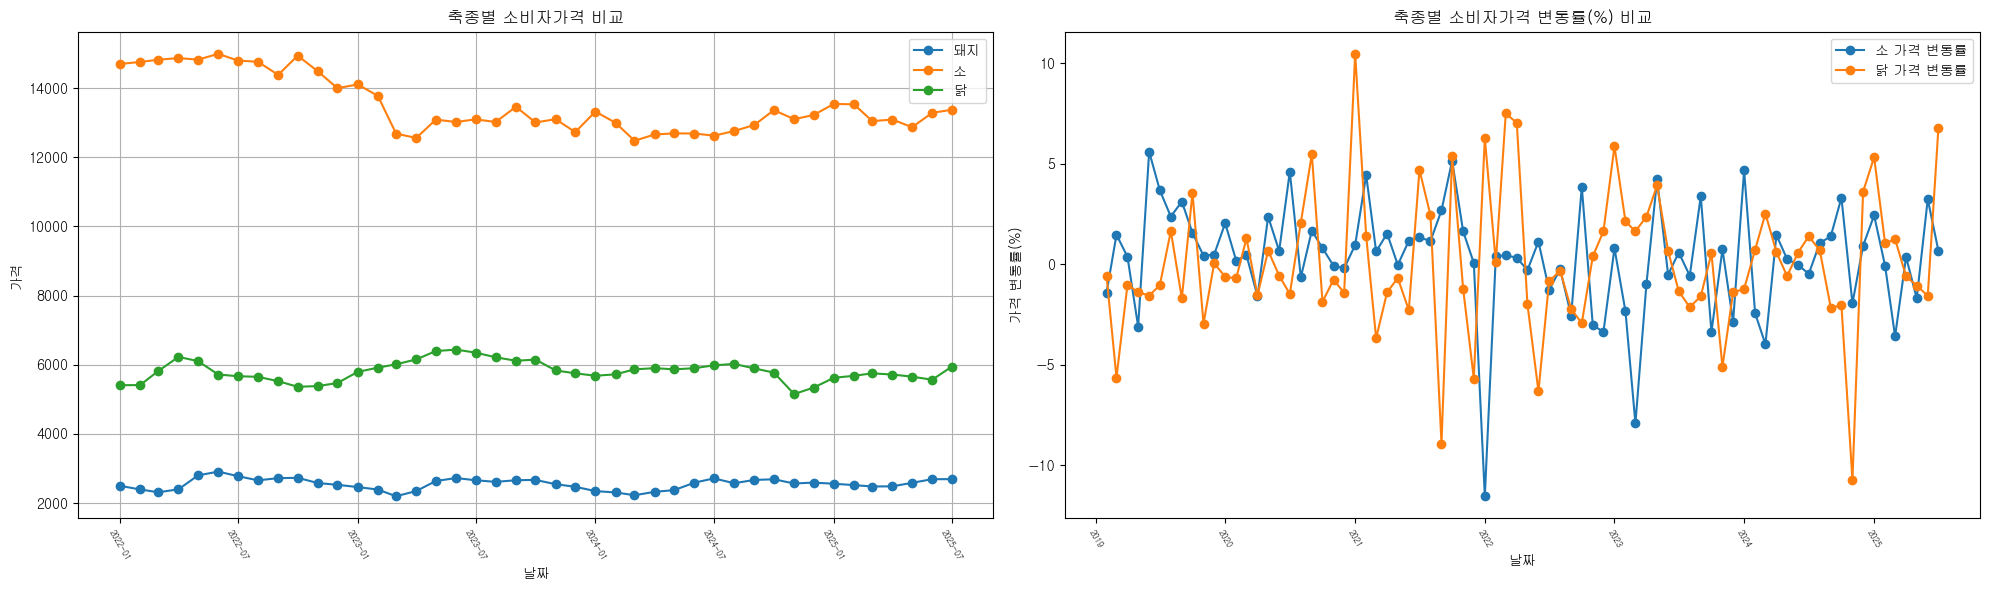

In [194]:
# 2019 축종별 소비자가격 비교
plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
plt.plot(dff_pivot.index, dff_pivot['돼지'], label='돼지', marker='o')
plt.plot(dff_pivot.index, dff_pivot['소'], label='소', marker='o')
plt.plot(dff_pivot.index, dff_pivot['닭'], label='닭', marker='o')
plt.title('축종별 소비자가격 비교')
plt.xlabel('날짜')
plt.xticks(fontsize=6, rotation=300)
plt.ylabel('가격')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.subplot(1, 2, 2)
# plt.plot(dff_pivot_pct.index, dff_pivot_pct['돼지'], label='돼지 가격 변동률', marker='o')
plt.plot(dff_pivot_pct.index, dff_pivot_pct['소'], label='소 가격 변동률', marker='o')
plt.plot(dff_pivot_pct.index, dff_pivot_pct['닭'], label='닭 가격 변동률', marker='o')
plt.title('축종별 소비자가격 변동률(%) 비교')
plt.xlabel('날짜')
plt.xticks(fontsize=6, rotation=300)
plt.ylabel('가격 변동률(%)')
plt.legend()
# plt.grid(True)
plt.tight_layout()
plt.show()

plt.show()

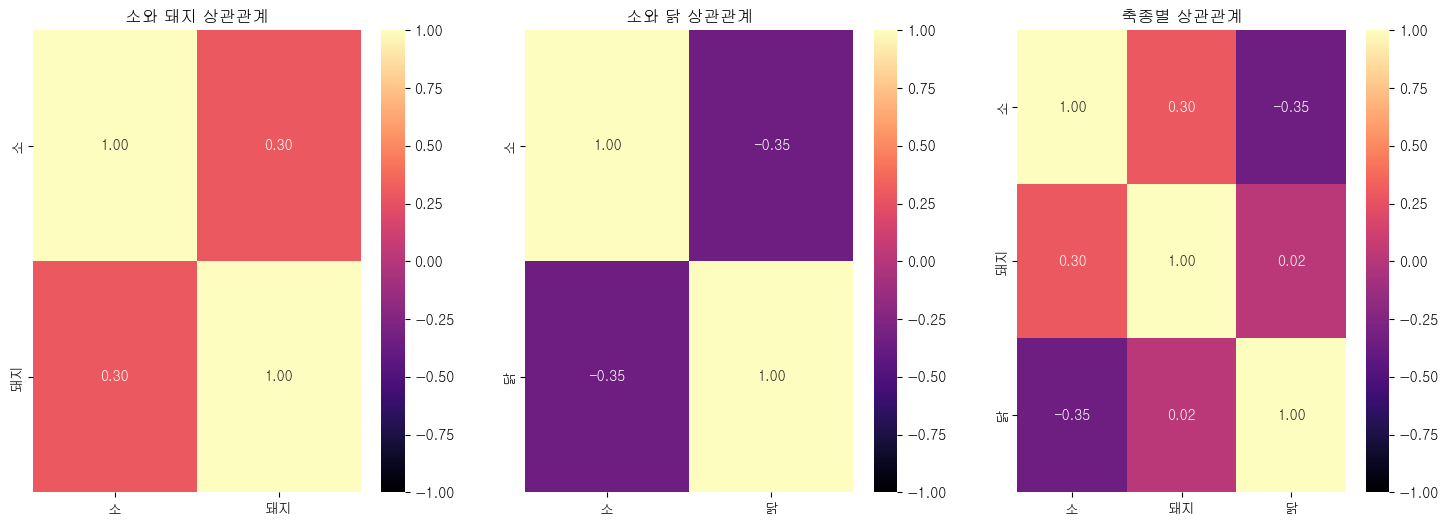

In [ ]:
# 2019~ 축종별 소비자가격 상관관계
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
corr_cp = dff_pivot[['소', '돼지']].corr()
sns.heatmap(corr_cp, annot=True, cmap='magma', fmt='.2f', vmin=-1, vmax=1)
plt.title('소와 돼지 상관관계')
plt.xlabel('')
plt.ylabel('')

plt.subplot(1, 3, 2)
corr_cc = dff_pivot[['소', '닭']].corr()
sns.heatmap(corr_cc, annot=True, cmap='magma', fmt='.2f', vmin=-1, vmax=1)
plt.title('소와 닭 상관관계')
plt.xlabel('')
plt.ylabel('')

plt.subplot(1, 3, 3)
meats = dff_pivot[['소', '돼지', '닭']]
corr = meats.corr()
sns.heatmap(corr, annot=True, cmap='magma', fmt='.2f', vmin=-1, vmax=1)
plt.title('축종별 상관관계')
plt.xlabel('')
plt.ylabel('')

plt.show()

<Figure size 1200x600 with 0 Axes>

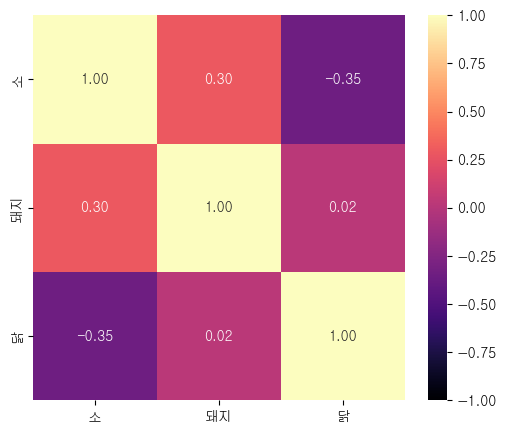

In [193]:
plt.figure(figsize=(12, 6))
meats = dff_pivot[['소', '돼지', '닭']]
corr = meats.corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap='magma', fmt='.2f', vmin=-1, vmax=1)
plt.xlabel('')
plt.ylabel('')

plt.show()

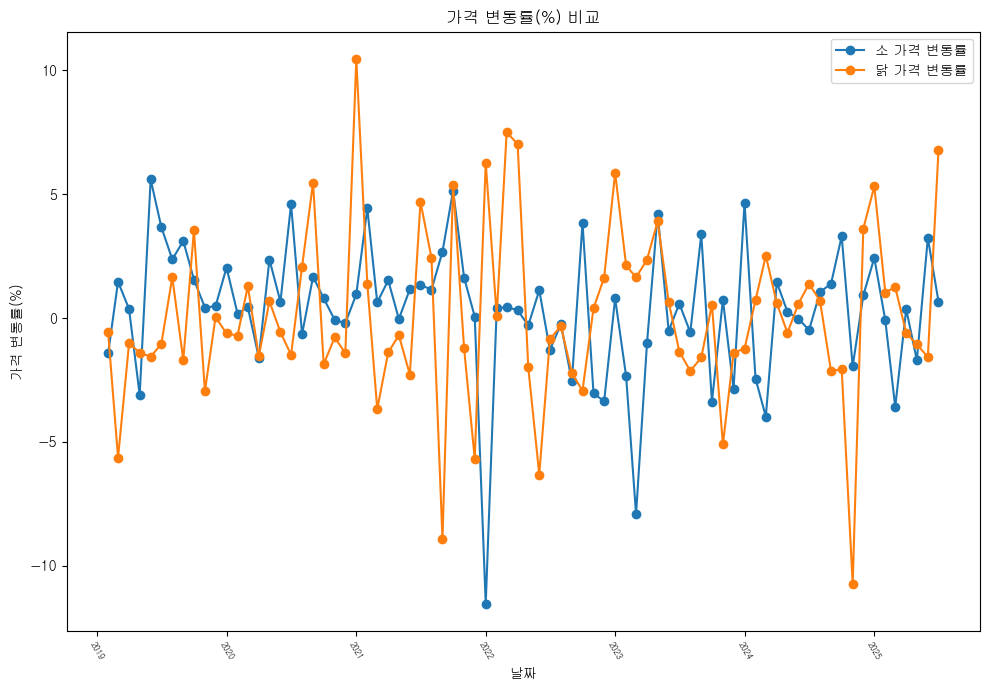

In [146]:
# 2019~ 가격 변동률

plt.figure(figsize=(10, 7))
# plt.plot(dff_pivot_pct.index, dff_pivot_pct['돼지'], label='돼지 가격 변동률', marker='o')
plt.plot(dff_pivot_pct.index, dff_pivot_pct['소'], label='소 가격 변동률', marker='o')
plt.plot(dff_pivot_pct.index, dff_pivot_pct['닭'], label='닭 가격 변동률', marker='o')
plt.title('가격 변동률(%) 비교')
plt.xlabel('날짜')
plt.xticks(fontsize=6, rotation=300)
plt.ylabel('가격 변동률(%)')
plt.legend()
# plt.grid(True)
plt.tight_layout()
plt.show()

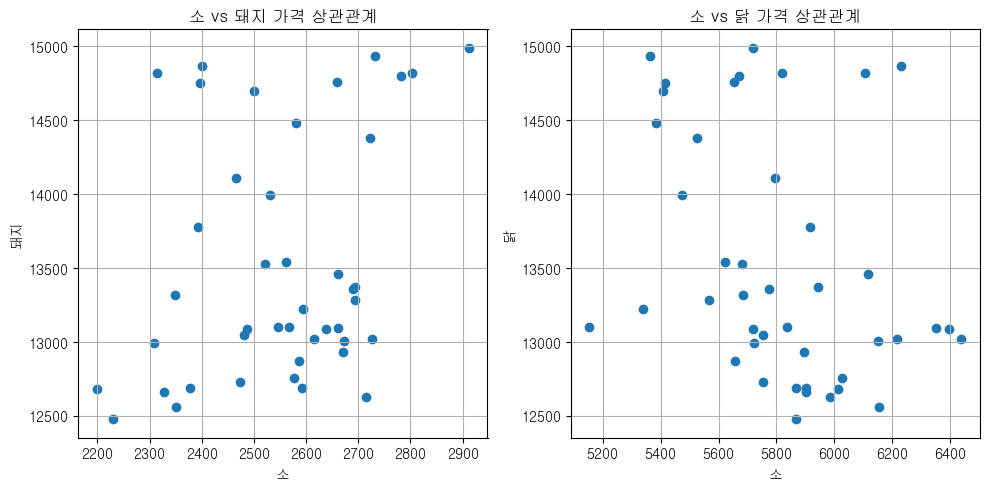

Index(['고기', '연도', '월', '가격', 'yyyydd', '날짜'], dtype='object')


In [ ]:
# 2019~ 가격 상관관계
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(dff_pivot['돼지'], dff_pivot['소'])
plt.xlabel('소')
plt.ylabel('돼지')
plt.title('소 vs 돼지 가격 상관관계')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(dff_pivot['닭'], dff_pivot['소'])
plt.xlabel('소')
plt.ylabel('닭')
plt.title('소 vs 닭 가격 상관관계')
plt.grid(True)

plt.tight_layout()
plt.show()

print(dff.columns)

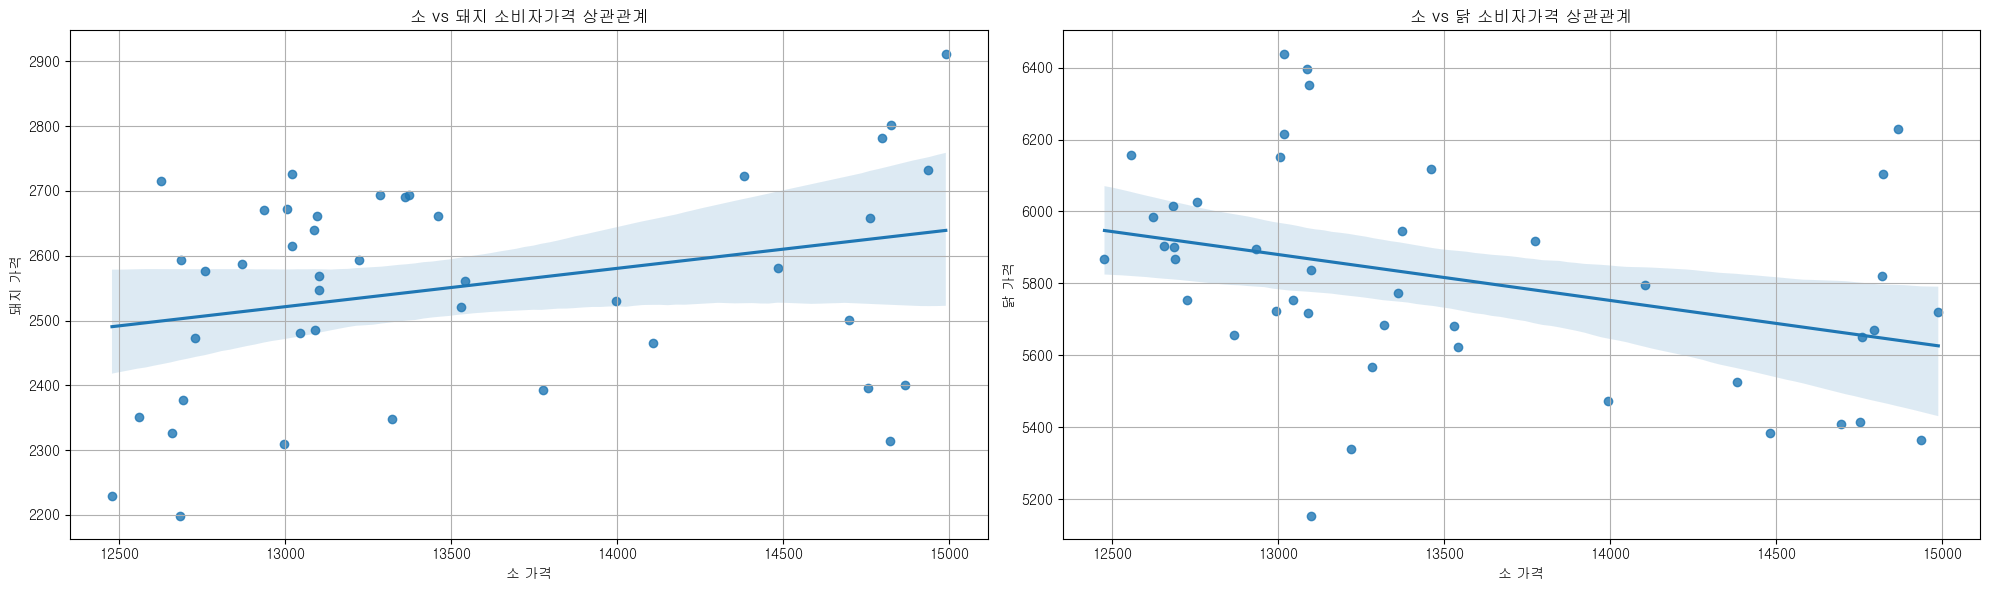

In [195]:
plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
sns.regplot(data=dff_pivot, x='소', y='돼지')
plt.title('소 vs 돼지 소비자가격 상관관계')
plt.xlabel('소 가격')
plt.ylabel('돼지 가격')
plt.grid(True)
plt.tight_layout()

plt.subplot(1, 2, 2)
sns.regplot(data=dff_pivot, x='소', y='닭')
plt.title('소 vs 닭 소비자가격 상관관계')
plt.xlabel('소 가격')
plt.ylabel('닭 가격')
plt.grid(True)
plt.tight_layout()

plt.show()

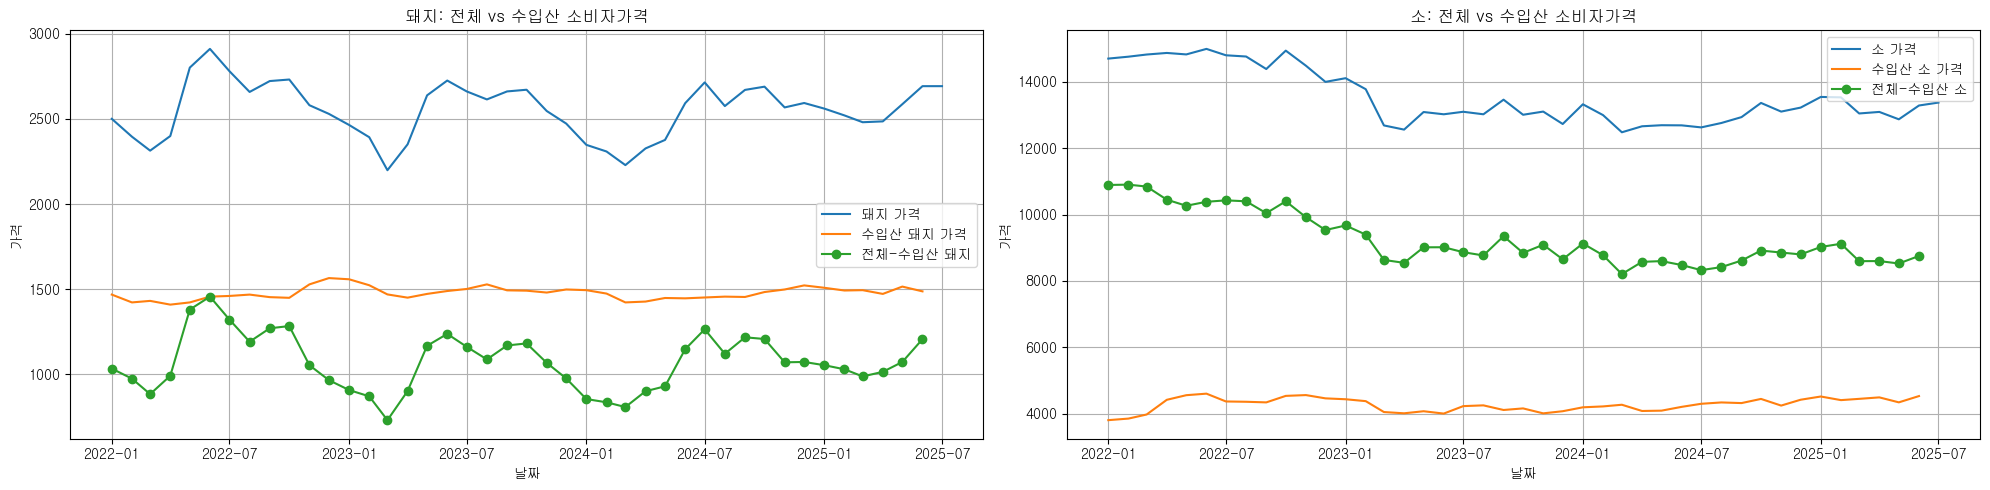

In [206]:
# 수입 가격과 소비자가격 비교 -1
start_date = '2022-01-01'
dff_pivot = dff_pivot[dff_pivot.index >= start_date]
imdf = imdf[imdf.index >= start_date]
dff_pivot['돼지_가격격차'] = dff_pivot['돼지'] - imdf['돼지']
dff_pivot['소_가격격차'] = dff_pivot['소'] - imdf['소']

plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.plot(dff_pivot.index, dff_pivot['돼지'], label='돼지 가격')
plt.plot(imdf.index, imdf['돼지'], label='수입산 돼지 가격')
plt.plot(dff_pivot.index, dff_pivot['돼지_가격격차'], label='전체-수입산 돼지', marker='o')
plt.title('돼지: 전체 vs 수입산 소비자가격')
plt.xlabel('날짜')
plt.ylabel('가격')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.subplot(1, 2, 2)
plt.plot(dff_pivot.index, dff_pivot['소'], label='소 가격')
plt.plot(imdf.index, imdf['소'], label='수입산 소 가격')
plt.plot(dff_pivot.index, dff_pivot['소_가격격차'], label='전체-수입산 소', marker='o')
plt.title('소: 전체 vs 수입산 소비자가격')
plt.xlabel('날짜')
plt.ylabel('가격')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

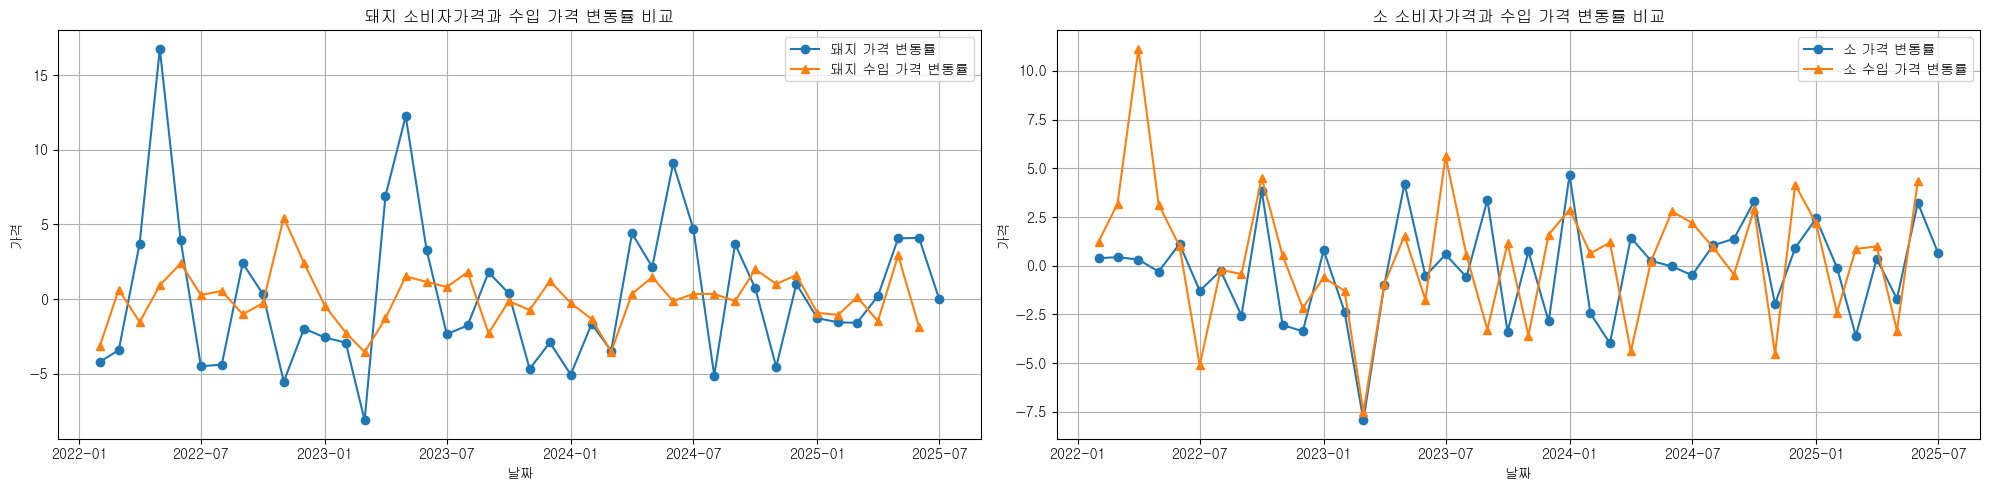

In [213]:
# 수입 가격과 소비자가격 변동률 비교 
start_date = '2022-01-02'
dff_pivot_date = dff_pivot_pct[dff_pivot_pct.index >= start_date]
imdf_date = imdf_pct[imdf_pct.index >= start_date]

plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.plot(dff_pivot_date.index, dff_pivot_date['돼지'], label='돼지 가격 변동률', marker='o')
plt.plot(imdf_date.index, imdf_date['돼지'], label='돼지 수입 가격 변동률', marker='^')
plt.title('돼지 소비자가격과 수입 가격 변동률 비교')
plt.xlabel('날짜')
plt.ylabel('가격')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.subplot(1, 2, 2)
plt.plot(dff_pivot_date.index, dff_pivot_date['소'], label='소 가격 변동률', marker='o')
plt.plot(imdf_date.index, imdf_date['소'], label='소 수입 가격 변동률', marker='^')
plt.title('소 소비자가격과 수입 가격 변동률 비교')
plt.xlabel('날짜')
plt.ylabel('가격')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

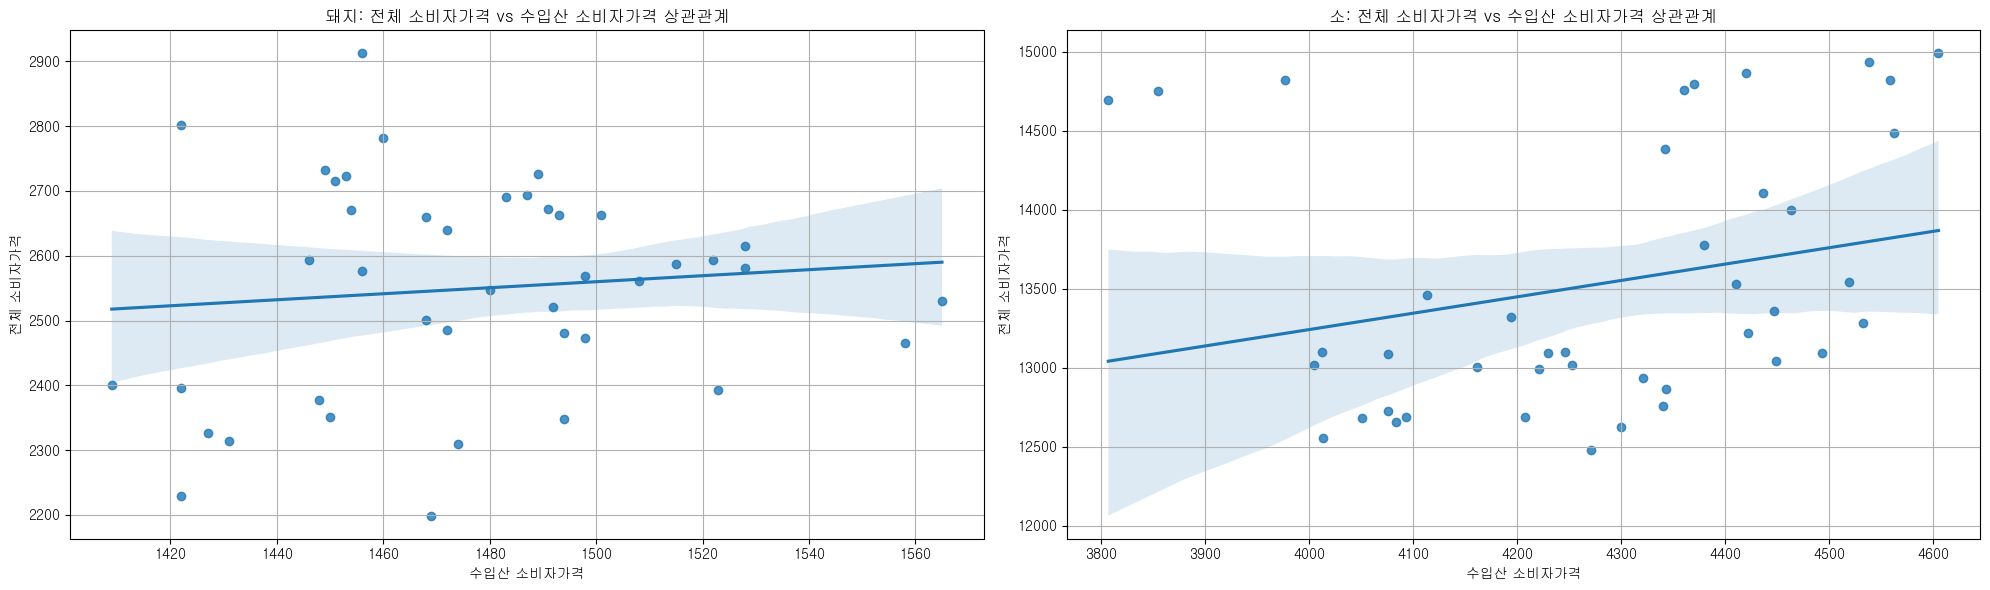

In [207]:
# 소비자가격과 수입가격 비교 -2
start_date = '2022-01-01'
dff_pivot = dff_pivot[dff_pivot.index >= start_date]
imdf = imdf[imdf.index >= start_date]

df_merge_pig = pd.merge(
    dff_pivot[['돼지']],       
    imdf[['돼지']],              
    left_index=True,
    right_index=True,
    suffixes=('_소비자', '_수입')
)

df_merge_cow = pd.merge(
    dff_pivot[['소']],         
    imdf[['소']],             
    left_index=True,
    right_index=True,
    suffixes=('_소비자', '_수입')
)

plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
sns.regplot(data=df_merge_pig, x='돼지_수입', y='돼지_소비자')
plt.title('돼지: 전체 소비자가격 vs 수입산 소비자가격 상관관계')
plt.xlabel('수입산 소비자가격')
plt.ylabel('전체 소비자가격')
plt.grid(True)
plt.tight_layout()

plt.subplot(1, 2, 2)
sns.regplot(data=df_merge_cow, x='소_수입', y='소_소비자')
plt.title('소: 전체 소비자가격 vs 수입산 소비자가격 상관관계')
plt.xlabel('수입산 소비자가격')
plt.ylabel('전체 소비자가격')
plt.grid(True)
plt.tight_layout()

plt.show()